# filters

> This module implements various filters to check for specific occurrences in the data

In [ ]:
# | default_exp filters


In [ ]:
# | hide
from nbdev.showdoc import *


In [ ]:
# | export
import pandas as pd
from datetime import datetime, timedelta
import nbdev
from stocksurfer.technicals import add_all_technicals, get_sma


In [ ]:
# | export
base_path = nbdev.config.get_config().lib_path


In [ ]:
# | export
processed_data_dir = base_path / "../Data/Bhavcopy/Processed/"
nifty500_csv = base_path / "../Data/Misc/ind_nifty500list.csv"


# Helper functions for filtering stocks with a given strategy.

In [ ]:
# | export
def get_nifty500():
    # Get Nifty500 list
    return pd.read_csv(nifty500_csv).Symbol.to_list()


In [ ]:
# | export
# Load data for a symbol
def get_symbol_data(symbol):
    file_path = base_path / processed_data_dir / f"{symbol}.parquet"

    if not file_path.exists():
        return None
    df = pd.read_parquet(file_path)
    df["DATE"] = pd.to_datetime(df["DATE"])  # apply(lambda x: x.strftime('%Y-%d-%m'))
    return df

In [ ]:
# | export
# Convert daily data to monthly data
def get_monthly_data(df):
    return (
        df.resample("M", on="DATE")
        .agg(
            {
                "OPEN": "first",
                "HIGH": "max",
                "LOW": "min",
                "CLOSE": "last",
                "SYMBOL": "first",
                "DATE": "first",
            }
        )
        .dropna()
        .reset_index(drop=True)
    )


# Convert daily data to weekly data
def get_weekly_data(df):
    return (
        df.resample("W", on="DATE")
        .agg(
            {
                "OPEN": "first",
                "HIGH": "max",
                "LOW": "min",
                "CLOSE": "last",
                "SYMBOL": "first",
                "DATE": "first",
            }
        )
        .dropna()
        .reset_index(drop=True)
    )

In [ ]:
# | export
def filter_stocks(
    symbols=None,
    timeframe="daily",
    cutoff_date=None,
    lookback=0,
    n_detections=0,
    strategy=None,
    strategy_args=None,
):
    if not symbols:
        symbols = get_nifty500()
    elif symbols == "all":
        symbols = [f.stem for f in processed_data_dir.glob("*.parquet")]
    for symbol in symbols:
        # print(symbol)
        df = get_symbol_data(symbol)
        if df is None:
            print(f"Data not found for {symbol}")
        elif len(df) < 202:
            # print(f"Data not sufficient for {symbol}: {len(df)} rows")
            pass
        else:
            # Filter data by cutoff data
            if cutoff_date:
                df = df.query("DATE < @cutoff_date")
            
            # Resample data to monthly or weekly
            if timeframe.lower() == "monthly":
                df = add_all_technicals(get_monthly_data(df))
            elif timeframe.lower() == "weekly":
                df = add_all_technicals(get_weekly_data(df))

            # Iteratively evaluate strategy for lookback period
            detection_count = 0
            for lb in range(min(lookback+1, len(df)-1)):
                df_lb = df.drop(df.tail(lb).index)

                # Pass strategy args to the strategy method and run it
                if strategy(df_lb, kwargs=strategy_args):
                    detection_count += 1
                    if detection_count == n_detections:
                        break

## 200-20 wedge

In [ ]:
df = add_all_technicals(get_weekly_data(get_symbol_data("UPL")))
 # Get df tail
df_tail = df.tail(15)

# Get 200-20 diff
tail_diff = df_tail.apply(lambda x: x.SMA_200_C - x.SMA_20_C, axis=1)

In [ ]:
all(tail_diff > 0)

False

<AxesSubplot:xlabel='DATE'>

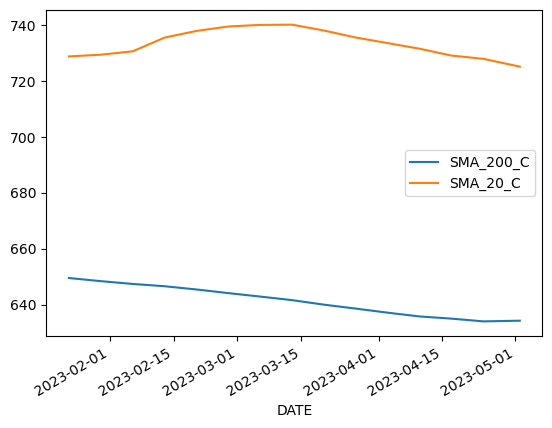

In [ ]:
df_tail.plot(x="DATE", y=["SMA_200_C", "SMA_20_C"])

<AxesSubplot:>

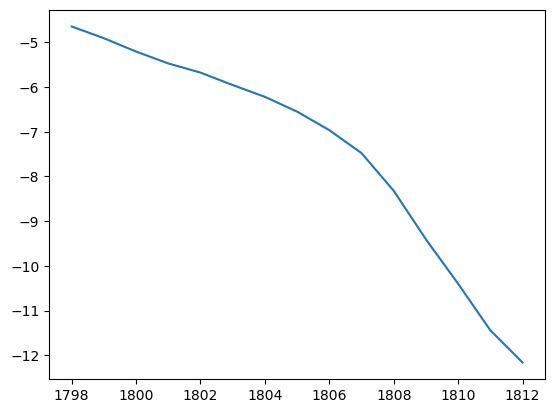

In [ ]:
# df_tail.plot(x="DATE", y=["SMA_200_C", "SMA_20_C"], figsize=(20, 10))
tail_diff.plot()

In [ ]:
# | export
# Check for a 200-20 wedge position
def wedge_200_20(df, kwargs=None):
    
    # Get args
    window = kwargs['window'] if kwargs and 'window' in kwargs.keys() else 12
    
    # Get df tail
    df_tail = df.tail(window)
    
    # Get 200-20 diff
    tail_diff = df_tail.apply(lambda x: x.SMA_200_C - x.SMA_20_C, axis=1)
    
    conditions = [
        
        # SMA 20 is rising
        df_tail.SMA_20_C.is_monotonic_increasing,
        
        # SMA 20 is roughly rising, calculated as 75% of candles are closing higher than previous candle
        # ((df_tail.SMA_20_C.diff() > 0).sum()+1)/(len(df_tail)) > 0.75,
        
        # SMA 200 and SMA 20 are converging
        tail_diff.is_monotonic_decreasing,

        # SMA 200 is above SMA 20
        all(tail_diff > 0),

        # SMA 200 and SMA 20 are within x% of each other
        all(tail_diff < df_tail.SMA_200_C * 0.2),
        
        # Any of these positions
        any([
            # Last candle has crossed SMA 200 with green candle
            df.iloc[-1].CLOSE > df.iloc[-1].SMA_200_C > df.iloc[-1].LOW,
            # Last candle is cleanly above SMA 200 and the one before spanned SMA 200 but closed below it
            df.iloc[-1].LOW > df.iloc[-1].SMA_200_C and df.iloc[-2].HIGH > df.iloc[-2].SMA_200_C > df.iloc[-2].LOW,
            # Last candle is cleanly above SMA 200 and the one before is cleanly below SMA 200
            df.iloc[-1].LOW > df.iloc[-1].SMA_200_C and df.iloc[-2].HIGH < df.iloc[-2].SMA_200_C,
        ]),
    
        
        # Candle before last has closed below SMA 200
        # df.iloc[-2].CLOSE < df.iloc[-2].SMA_200_C,
        
        # Body of last candle should be bigger than upper and lower wick
        df.iloc[-1].CLOSE - df.iloc[-1].OPEN > df.iloc[-1].HIGH - df.iloc[-1].CLOSE,
        df.iloc[-1].CLOSE - df.iloc[-1].OPEN > df.iloc[-1].OPEN - df.iloc[-1].LOW,
        
        # SMA 20 crosses over SMA 200 from below
        # df.iloc[-1].SMA_20_C > df.iloc[-1].SMA_200_C,
        # df.iloc[-2].SMA_20_C < df.iloc[-2].SMA_200_C,

        # df.iloc[-2].CLOSE < df.iloc[-2].SMA_200_C,
        # df.iloc[-3].CLOSE < df.iloc[-3].SMA_200_C,

    ]

    if all(conditions):
        print(f"{df.iloc[-1].SYMBOL} is in a 200-20 wedge position {df.DATE.iloc[-1].date()} at {df.iloc[-1].CLOSE}")
        return True
    return False

In [ ]:
filter_stocks(
    symbols=["RECLTD"],
    timeframe="weekly",
    # cutoff_date=datetime(2023, 4, 11),
    strategy=wedge_200_20,
    lookback = 5,
    n_detections=1,
    strategy_args={"window": 10},
)

RECLTD is in a 200-20 wedge position 2023-04-24 at 132.15


## Single candle span

In [ ]:
# | export
# Check if the latest candle spans the given SMAs
def single_candle_span(df, kwargs=None):
    if kwargs and "col_list" in kwargs.keys():
        col_list = kwargs["col_list"]
    else:
        col_list = ["SMA_20_C", "SMA_200_C"]

    conditions = [
        df.LOW.iloc[-1] <= df[col].iloc[-1] <= df.HIGH.iloc[-1] for col in col_list
    ]
    if all(conditions):
        print(f"{df.SYMBOL.iloc[0]} -> Single candle span on {df.DATE.iloc[-1].date()}")
        return True
    return False

In [ ]:
filter_stocks(
    timeframe="weekly",
    cutoff_date=datetime(2023, 5, 3),
    strategy=single_candle_span,
    # strategy_args={"col_list": ["SMA_20_C", "SMA_200_C", "SMA_44_C"]},
)

## Hammer on BBL

In [ ]:
# | export
# Check if the latest candle is a hammer
def hammer_on_BBL(df, kwargs=None):
    body = df.iloc[-1].CLOSE - df.iloc[-1].OPEN
    upper_wick = df.iloc[-1].HIGH - df.iloc[-1].CLOSE
    lower_wick = df.iloc[-1].OPEN - df.iloc[-1].LOW

    conditions = [
        df.iloc[-1].CLOSE > df.iloc[-1].OPEN,
        lower_wick >= 2 * body,
        body >= 1.5 * upper_wick,
        df.iloc[-1].CLOSE > df.iloc[-1].BBL_20_2 > df.iloc[-1].LOW,
    ]

    if all(conditions):
        print(f"{df.SYMBOL.iloc[0]} -> Hammer on BBL on {df.DATE.iloc[-1].date()}")
        return True
    return False

In [ ]:
filter_stocks(
    timeframe="weekly",
    # cutoff_date=datetime(2023,4, 27),
    strategy=hammer_on_BBL,
)


## Green takes out red

In [ ]:
# | export
# Check if latest candle is green takes out red on BBL
def green_engulfing_on_BBL(df, kwargs=None):
    conditions = [
        df.iloc[-2].CLOSE < df.iloc[-2].OPEN,
        df.iloc[-1].CLOSE > df.iloc[-1].OPEN,
        df.iloc[-1].LOW < df.iloc[-1].BBL_20_2 < df.iloc[-1].HIGH,
        df.iloc[-1].CLOSE > df.iloc[-2].OPEN,
    ]

    if all(conditions):
        print(
            f"{df.SYMBOL.iloc[0]} -> Green engulfing on BBL on {df.DATE.iloc[-1].date()}"
        )
        return True
    return False

In [ ]:
filter_stocks(
    symbols="all",
    timeframe="weekly",
    # cutoff_date=datetime(2023,3, 31),
    strategy=green_engulfing_on_BBL,
)


## Three rising green candles

In [ ]:
# | export
# Check for three rising green candles
def three_rising_green_candles_on_SMA20(df, kwargs=None):
    conditions = [
        df.iloc[-1].CLOSE > df.iloc[-1].OPEN,
        df.iloc[-2].CLOSE > df.iloc[-2].OPEN,
        df.iloc[-3].CLOSE > df.iloc[-3].OPEN,
        df.iloc[-1].CLOSE > df.iloc[-2].CLOSE,
        df.iloc[-2].CLOSE > df.iloc[-3].CLOSE,
        df.iloc[-3].CLOSE > df.iloc[-3].SMA_20_C,
        df.iloc[-3].LOW < df.iloc[-3].SMA_20_C,
    ]

    if all(conditions):
        print(
            f"{df.SYMBOL.iloc[0]} -> Three rising green candles on {df.DATE.iloc[-1].date()}"
        )
        return True
    return False

In [ ]:
filter_stocks(
    timeframe="weekly",
    # cutoff_date=datetime(2023,4, 27),
    strategy=three_rising_green_candles_on_SMA20,
)


## SMA catch

In [ ]:
# | export
# Check for SMA 20 catch
def level_catch(df, kwargs=None):
    if kwargs and "level" in kwargs.keys():
        conditions = [
            df.iloc[-1].CLOSE > df.iloc[-1].OPEN,
            df.iloc[-2].CLOSE > df.iloc[-2].OPEN,
            df.iloc[-2].LOW < df.iloc[-2][kwargs['level']],
            df.iloc[-1].LOW > df.iloc[-1][kwargs['level']],
            df.iloc[-1].CLOSE > df.iloc[-2].CLOSE,
        ]

        if all(conditions):
            print(f"{df.SYMBOL.iloc[0]} -> {kwargs['level']} catch on {df.DATE.iloc[-1].date()}")
            return True
    else:
        print("Level not specified")
    return False

In [ ]:
filter_stocks(
    # symbols=["APOLLOTYRE"],
    # timeframe="monthly",
    # cutoff_date=datetime(2023,4, 20),
    lookback=1,
    strategy=level_catch,
    strategy_args={'level':"SMA_200_C"},
)

AIAENG -> SMA_200_C catch on 2023-05-02
AARTIDRUGS -> SMA_200_C catch on 2023-05-03
BERGEPAINT -> SMA_200_C catch on 2023-05-02
CASTROLIND -> SMA_200_C catch on 2023-05-02
CHOLAHLDNG -> SMA_200_C catch on 2023-05-02
DELTACORP -> SMA_200_C catch on 2023-05-03
EICHERMOT -> SMA_200_C catch on 2023-05-02
IBREALEST -> SMA_200_C catch on 2023-05-02
Data not found for PATANJALI
SAIL -> SMA_200_C catch on 2023-05-02
TATACOFFEE -> SMA_200_C catch on 2023-05-02
TATACONSUM -> SMA_200_C catch on 2023-05-03
WELCORP -> SMA_200_C catch on 2023-05-02


## Alltime high

In [ ]:
#| export
# Check for alltime high
def alltime_high(df, kwargs=None):
    df2 = df[:-1]
    conditions = [
        df.iloc[-1].CLOSE >= df2.HIGH.max(),
        df.iloc[-2].CLOSE < df2.HIGH.max(),
        
        df.iloc[-3].CLOSE < df2.HIGH.max(),
        df.iloc[-4].CLOSE < df2.HIGH.max(),
        df.iloc[-5].CLOSE < df2.HIGH.max(),
    ]
    
    if all(conditions):
        print(f"{df.SYMBOL.iloc[0]} -> All time high on {df.DATE.iloc[-1].date()}")
        return True
    return False

In [ ]:
filter_stocks(
    # symbols=["TWL"],
    timeframe="monthly",
    # cutoff_date=datetime(2022,12, 1),
    # lookback=3,
    strategy=alltime_high,
)

ANURAS -> All time high on 2023-04-03
APOLLOTYRE -> All time high on 2023-04-03
BAJAJ-AUTO -> All time high on 2023-04-03
CCL -> All time high on 2023-04-03
CARBORUNIV -> All time high on 2023-04-03
FINCABLES -> All time high on 2023-04-03
HAL -> All time high on 2023-04-03
ITC -> All time high on 2023-04-03
KEI -> All time high on 2023-04-03
LT -> All time high on 2023-04-03
NAVINFLUOR -> All time high on 2023-04-03
NESTLEIND -> All time high on 2023-04-03
Data not found for PATANJALI
POLYCAB -> All time high on 2023-04-03
RVNL -> All time high on 2023-04-03
SIEMENS -> All time high on 2023-04-03
SUNDRMFAST -> All time high on 2023-04-03
VBL -> All time high on 2023-04-03


## Next

# Draft

20 SMA HALT STRATEGY

In [ ]:
def check_directional_crossover(df, col1, col2, days_lookback=7):
    days_lookback = min(days_lookback + 1, df.shape[0])
    for d in range(1, days_lookback):
        # print(f"Checking for {df.DATE.iloc[-d]}: {df[col1].iloc[-d]}, {df[col2].iloc[-d]}")
        if (
            df[col1].iloc[-d] > df[col2].iloc[-d]
            and df[col1].iloc[-d - 1] < df[col2].iloc[-d - 1]
        ):
            # print(f"{col1} crossed over {col2} on {df.DATE.iloc[-d]} : {d} days ago")
            return d
    return 0

In [ ]:
def check_close_under_falling_20(df, d, days_lookback=10):
    df = df.iloc[-d - days_lookback : -d]
    # print(df.DATE.iloc[0], df.DATE.iloc[-1])
    # df.plot(x="DATE", y=["CLOSE", "SMA_20_C"], figsize=(15, 5))
    # df.plot(x="DATE", y=["CLOSE", "SMA_20_C", "SMA_20_H"], figsize=(15, 5))
    # print(df.SMA_20_C.is_monotonic_decreasing, df.SMA_20_H.is_monotonic_decreasing)
    return all(
        [
            any(
                [
                    df.SMA_20_C.is_monotonic_decreasing,
                    df.SMA_20_H.is_monotonic_decreasing,
                    df.SMA_44_C.is_monotonic_decreasing,
                ]
            ),
            any(
                [
                    all(df.CLOSE < df.SMA_20_H),
                    # all(df.CLOSE < df.SMA_20_C)
                ]
            ),
            # all(df.SMA_200_C < df.SMA_20_C)
        ]
    )


# check_close_under_20(df, 15, 18)

In [ ]:
def check_close_above_20(df, d, days_lookfwd=3):
    df = df.iloc[-d + 1 :].head(days_lookfwd)
    # print(df)
    # print(df.DATE.iloc[0], df.DATE.iloc[-1])
    # df.plot(x="DATE", y=["CLOSE", "SMA_20_C"], figsize=(15, 5))
    return all(df.CLOSE > df.SMA_20_C)  # df.SMA_20_C.is_monotonic_increasing and

In [ ]:
def check_20_200_breakout(df, days_lookback=5):
    found = False
    col1 = "CLOSE"
    col2 = "SMA_20_C"
    col3 = "SMA_200_C"
    col4 = "SMA_20_H"
    # df = df[:-45]

    # Check for double crossover on SMA20 and SMA200 within a 3 day period
    dc20 = check_directional_crossover(df, col1, col2, days_lookback=days_lookback)
    if all(
        [
            dc20 > 0,
            check_close_under_falling_20(df, dc20, days_lookback=30),
            check_close_above_20(df, dc20),
        ]
    ):
        found = True
        dc200 = check_directional_crossover(df, col1, col3, days_lookback=days_lookback)
        # print(dc20, dc200)

        if all([dc200 > 0, abs(dc20 - dc200) < 3]):
            print(
                f"{df.SYMBOL.iloc[0]} -> Double crossover on {df.DATE.iloc[-dc20]} : {dc20} days ago, with {df.iloc[-dc20].CDL_COLOR} candle"
            )
        else:
            print(
                f"{df.SYMBOL.iloc[0]} -> SMA20 crossover on {df.DATE.iloc[-dc20]} : {dc20} days ago, with {df.iloc[-dc20].CDL_COLOR} candle"
            )
            if dc200:
                print(
                    f"{df.SYMBOL.iloc[0]} -> SMA 200 crossover: {df.DATE.iloc[-dc200]} : {dc200} days ago, with {df.iloc[-dc200].CDL_COLOR} candle"
                )
    return found

In [ ]:
def check_3_green_on_sma20(df):
    crossover = check_directional_crossover(df, "CLOSE", "SMA_20_C", days_lookback=15)
    if all(
        [
            crossover > 2,
            df.iloc[-crossover].CDL_COLOR == "green",
            df.iloc[-crossover + 1].CDL_COLOR == "green",
            df.iloc[-crossover + 2].CDL_COLOR == "green",
            df.iloc[-crossover + 1].CLOSE > df.iloc[-crossover].CLOSE,
            df.iloc[-crossover + 2].CLOSE > df.iloc[-crossover + 1].CLOSE,
            df.iloc[-crossover + 2].CLOSE < df.iloc[-crossover + 2].BBU_20_2,
            # df.iloc[-crossover].BBB_20_2 > 8,
            df.iloc[-crossover + 1].SMA_20_C > df.iloc[-crossover - 1].SMA_20_C
            # crossover > 10,
        ]
    ):
        max_close = max(df[-crossover + 1 :].CLOSE)
        perc_movement = (
            100
            * (max_close - df.iloc[-crossover + 2].CLOSE)
            / df.iloc[-crossover + 2].CLOSE
        )
        print(
            f"{df.SYMBOL.iloc[0]} -> SMA20 crossover on {df.DATE.iloc[-crossover]} : BBB = {df.BBB_20_2.iloc[-crossover]:0.2f} : Moved {perc_movement:.2f}%, upto {max_close}"
        )
    # else:
    #     print(crossover)


# df[-crossover-5:-crossover + 5][["DATE", "CLOSE", "SMA_20_C"]]

In [ ]:
# for symbol in df500:
#     df = get_symbol_data(symbol)
#     if df is not None:
#         check_3_green_on_sma20(df)


In [ ]:
# df = get_symbol_data("PNB")
# window = 500
# df.tail(window).plot(
#     x="DATE",
#     y=[
#         # "BBU_20_2",
#         # "BBM_20_2",
#         # "BBL_20_2",
#         "BBB_20_2",
#         # "BBP_20_2",
#         "CLOSE"
#     ],
#     figsize=(18, 15),
# )
# df.tail(window).plot(
#     x="DATE",
#     y=[
#         "CLOSE"
#     ],
#     figsize=(18, 5),
# )


SMA 20 & SMA 200 Strategies

In [ ]:
# Find stocks with SMA20 and SMA44 single candle span
# for symbol in df500:
#     df = get_symbol_data(symbol)
#     if df is not None:
#         check_single_candle_span(
#             df, col_list=["SMA_20_C", "SMA_44_C", "SMA_200_C"], days_lookback=2
#         )


In [ ]:
# Find stocks with 20ma crossover preceded by time under a falling SMA20
# for symbol in df500:
#     df = get_symbol_data(symbol)
#     if df is not None:
#         a = check_20_200_breakout(df)
#         if a:
#             b = check_single_candle_span(
#                 df, col_list=["SMA_20_C", "SMA_44_C", "SMA_200_C"], days_lookback=5
#             )
#             print("-" * 100)


ALLTIME HIGH STRATEGY

In [ ]:
def check_historical_minmax(df, min_steps_back=30, mode=None):
    if mode is None or mode == "all":
        mode = ["min", "max"]

    if "DATE" not in df.columns:
        df["DATE"] = df.index

    max_steps = len(df)
    if max_steps > min_steps_back:
        if "max" in mode or mode == "max":
            # Search for historical high
            last_is_max = True
            steps_back = 1
            while last_is_max:
                steps_back += 1
                if steps_back > max_steps:
                    print(
                        f"{df.SYMBOL.iloc[-1]}: ALL TIME HIGH on {df.DATE.iloc[-1].date()} closed at {df.CLOSE.iloc[-1]}"
                    )
                    return
                last_is_max = df.CLOSE.iloc[-1] >= df.HIGH.iloc[-steps_back]

            if steps_back >= min_steps_back:
                print(
                    f"{df.SYMBOL.iloc[-1]} CLOSE -> {df.CLOSE.iloc[-1]} : New high of {steps_back} sessions, since HIGH of {df.HIGH.iloc[-steps_back]} on {df.DATE.iloc[-steps_back].date()}"
                )

        if "min" in mode or mode == "min":
            # Search for historical low
            last_is_min = True
            steps_back = 1
            while last_is_min:
                steps_back += 1
                if steps_back > max_steps:
                    print(
                        f"{df.SYMBOL.iloc[-1]}: ALL TIME LOW on {df.DATE.iloc[-1].date()} closed at {df.CLOSE.iloc[-1]}"
                    )
                    return
                last_is_min = df.CLOSE.iloc[-1] <= df.LOW.iloc[-steps_back]

            if steps_back >= min_steps_back:
                print(
                    f"{df.SYMBOL.iloc[-1]} CLOSE -> {df.CLOSE.iloc[-1]} : New low of {steps_back} sessions, since LOW of {df.LOW.iloc[-steps_back]} on {df.DATE.iloc[-steps_back].date()}"
                )

In [ ]:
symbol = "BAJAJFINSV"
file_path = base_path / processed_data_dir / f"{symbol}.csv"
if not file_path.exists():
    print(f"File does not exist: {file_path}")
else:
    print(f"File exists: {file_path}")
    df = pd.read_csv(file_path, parse_dates=["DATE"])
    # Convert daily data to monthly data
    df_monthly = df.resample("M", on="DATE").agg(
        {
            "OPEN": "first",
            "HIGH": "max",
            "LOW": "min",
            "CLOSE": "last",
            "SYMBOL": "first",
        }
    )

    check_historical_minmax(df, min_steps_back=4, mode=None)
    # check_historical_minmax(df_monthly, min_steps_back=4, mode=None)


In [ ]:
# for symbol in df500:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if file_path.exists():
#         df = pd.read_csv(file_path, parse_dates=["DATE"])
#         # Convert daily data to monthly data
#         df_monthly = df.resample("M", on="DATE").agg(
#             {
#                 "OPEN": "first",
#                 "HIGH": "max",
#                 "LOW": "min",
#                 "CLOSE": "last",
#                 "SYMBOL": "first",
#             }
#         )

#         # check_historical_minmax(df, min_steps_back=30, mode="max")
#         check_historical_minmax(df_monthly, min_steps_back=36, mode="all")


In [ ]:
# Get list of all csv files in raw_data_dir
# csv_files = [f for f in raw_data_dir.iterdir() if f.suffix == '.csv']

# for file in csv_files:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if os.path.exists(file_path):
#         df = pd.read_csv(file_path, parse_dates=["DATE"])

#         # Convert daily data to monthly data
#         df_monthly = df.resample('M', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})

#         # check_historical_minmax(df, min_steps_back=300, mode="max")
#         check_historical_minmax(df_monthly, min_steps_back=60, mode="max")


Movement in a band

In [ ]:
def check_movement_within_band(df, band_perc=5, steps_lookback=20):
    steps_lookback = min(steps_lookback + 1, df.shape[0])
    max_steps = len(df)

    band_max = df.CLOSE.iloc[-1] * (1 + band_perc / 100)
    band_min = df.CLOSE.iloc[-1] * (1 - band_perc / 100)

    in_band = True
    steps_back = 1
    while in_band:
        steps_back += 1
        if steps_back > max_steps:
            print(
                f"{df.SYMBOL.iloc[-1]}: Within band of {band_perc}% for {steps_back-1} sessions for band: {band_min:0.2f} to {band_max:0.2f}"
            )
            return
        in_band = (df.CLOSE.iloc[-steps_back] <= band_max) and (
            df.CLOSE.iloc[-steps_back] >= band_min
        )

    if steps_back >= steps_lookback:
        print(
            f"{df.SYMBOL.iloc[-1]} CLOSE -> {df.CLOSE.iloc[-1]} : Within band of {band_perc}% for {steps_back-1} sessions for band: {band_min:0.2f} to {band_max:0.2f}"
        )
        return


In [ ]:
# symbol = "VAIBHAVGBL"
# file_path = base_path / processed_data_dir / f"{symbol}.csv"
# if not os.path.exists(file_path):
#     print(f"File does not exist: {file_path}")
# else:
#     print(f"File exists: {file_path}")
#     df = pd.read_csv(file_path, parse_dates=["DATE"])
#     df = df.query("DATE < '2022-08-27'")
#     check_movement_within_band(df, band_perc=5, steps_lookback=20)

# Convert daily data to monthly data
# df_monthly = df.resample('M', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})


In [ ]:
# for symbol in df500:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if os.path.exists(file_path):
#         df = pd.read_csv(file_path, parse_dates=["DATE"])

#         check_movement_within_band(df, band_perc=3, steps_lookback=20)


In [ ]:
# def check_3_green_on_SMA(df, sma_period=20):

#     if df.shape[0] < sma_period:
#         return

#     if all([
#         df.OPEN.iloc[-3] < df.SMA_20_C.iloc[-3] < df.CLOSE.iloc[-3],
#         df.OPEN.iloc[-2] < df.CLOSE.iloc[-2],
#         df.OPEN.iloc[-1] < df.CLOSE.iloc[-1],
#         df.CLOSE.iloc[-1] > df.CLOSE.iloc[-2] > df.CLOSE.iloc[-3],
#     ]): # 3 green candles on SMA

#         print(f"{df.SYMBOL.iloc[-1]}: 3 green candles on SMA 20 on {df.DATE.iloc[-1]}")


In [ ]:
# Get list of all csv files in raw_data_dir
# csv_files = [f for f in os.listdir(processed_data_dir) if f.endswith('.csv')]

# for file in csv_files:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if os.path.exists(file_path):
#         df = pd.read_csv(file_path, parse_dates=["DATE"])

#         # Convert daily data to monthly data
#         # df_monthly = df.resample('M', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})

#         # Convert daily data to weekly data
#         df_weekly = df.resample('W', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})
#         df_weekly['SMA_20_C'] = df_weekly.CLOSE.rolling(20).mean()
#         if "DATE" not in df_weekly.columns:
#             df_weekly["DATE"] = df_weekly.index

#         check_3_green_on_SMA(df_weekly, sma_period=20)


In [ ]:
# Download csv from URL
# url = r"https://www.nseindia.com/api/equity-stockIndices?csv=true&index=SECURITIES%20IN%20F%26O"
# df = pd.read_csv(url)
# df

In [ ]:
# import requests
# # Download csv from URL using requests
# url = r"https://www.nseindia.com/api/equity-stockIndices?csv=true&index=SECURITIES%20IN%20F%26O"
# requests.get(url).content

In [ ]:
# https://www.nseindia.com/market-data/live-equity-market

# https://www.nseindia.com/api/equity-stockIndices?csv=true&index=NIFTY%20SMALLCAP%2050

In [ ]:
# init_cap = 200000
# win_rate = 0.6
# one_trade_perc = 0.02

# for i in range(200):
#     if random.random() < win_rate:
#         init_cap = init_cap * (1 + one_trade_perc)
#     else:
#         init_cap = init_cap * (1 - one_trade_perc)

# print(f'{init_cap:,}')


In [ ]:
# import random
# random.random()


In [ ]:
# | hide
nbdev.nbdev_export()
